In [2]:
from IPython.core.display import display, HTML
from scipy.spatial.transform import Rotation
display(HTML("<style>.container { width:100% !important; }</style>"))
import h5py
from matplotlib import pyplot as plt
import torch
import numpy as np
from pathlib import Path
import glob
import os
import h5py
import numpy as np
import prody
import prody as pr
from potsim2 import PotGrid
import sklearn
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import f1_score
import os
import pandas as pd


import matplotlib
#matplotlib.use('TkAgg')

%matplotlib inline

In [3]:
def yieldData(predbase, testData):

    for fname in glob.glob(f'{testData}/*/*_pocket.pdb'):
        pocketfname = Path(fname)
        name = pocketfname.parent.name
        predfname = f'{predbase}/{name}/pocket_pred.pdb'
        pdbfname = f'{testData}/{name}/{name}_selected.pdb'

        
        pocket = prody.parsePDB(pocketfname)
        structure = prody.parsePDB(pdbfname)
        
        size = len(structure)

        try:
            pred = prody.parsePDB(predfname)
            yield name, (structure, pred, pocket), size
            
        except OSError:
            if os.path.exists(predfname+'.empty'):
                print(f'No pockets predicted for {name}, {predbase}')
                yield name, (structure, None, pocket), size
            else:
                print(f'Prediction for name {name} was not found')
        

        
def calcMetric(pred, pocket, structure, scoref):
    if pred is None:
        prednums = set()
    else:
        prednums = set(t.getResnum() for t in pred.iterResidues())
    truenums = set(t.getResnum() for t in pocket.iterResidues())
    allnums = set(t.getResnum() for t in structure.iterResidues())

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    y_true = []
    y_pred = []

    for num in allnums:
        if num not in prednums and num not in truenums:
            tn += 1
            y_pred.append(-1)
            y_true.append(-1)
        elif num not in prednums and num in truenums:
            fn += 1
            y_pred.append(-1)
            y_true.append(1)
        elif num in prednums and num not in truenums:
            fp += 1
            y_pred.append(1)
            y_true.append(-1)
        elif num in prednums and num in truenums:
            tp += 1
            y_pred.append(1)
            y_true.append(1)
        else:
            raise Exception

    return scoref(y_true, y_pred)

def scoresFromGen(gen):
    names = []
    mcc_scores = []
    f_scores = []
    for (name, (structure, pred, pocket), size) in gen:
        yield name, (calcMetric(pred, pocket, structure, f1_score), calcMetric(pred, pocket, structure, mcc)), size

In [5]:
testData = f'/home/lorenzo/3dunet-cavity/procData_210821'

predname = '210914_features_rot_log'
predbase = f'/home/lorenzo/3dunet-cavity/runs/{predname}/predictions'

predbaseKala = '/home/lorenzo/kalasanty/predictions_210821'

In [6]:
resOurs = list(scoresFromGen(yieldData(predbase, testData)))
resTheirs = list(scoresFromGen(yieldData(predbaseKala, testData)))

Prediction for name 4q19 was not found
Prediction for name 1sw2 was not found
Prediction for name 4bcn was not found
Prediction for name 4da5 was not found
Prediction for name 2q89 was not found
Prediction for name 2wca was not found
Prediction for name 5yhe was not found
Prediction for name 5vi6 was not found
Prediction for name 5hjq was not found
Prediction for name 3fjg was not found
Prediction for name 2vb8 was not found
Prediction for name 1lnm was not found
Prediction for name 6mjf was not found
Prediction for name 1rnt was not found
Prediction for name 5hcv was not found
Prediction for name 2jfz was not found
Prediction for name 2x6x was not found
Prediction for name 2dw7 was not found
Prediction for name 2gsu was not found
Prediction for name 2jdu was not found
Prediction for name 2yfx was not found
Prediction for name 4pf5 was not found
Prediction for name 3aaq was not found
Prediction for name 1r9l was not found
Prediction for name 5ey0 was not found
Prediction for name 6exi 

KeyboardInterrupt: 

In [17]:
# Our F scores

codes = [code for code,_,_ in resOurs]
sizes = [size for _,_,size in resOurs]
scores = [score for _,(score,_),_ in resOurs]

Text(0, 0.5, 'f score')

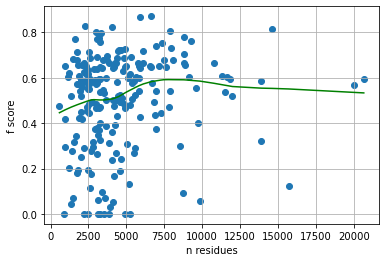

In [37]:
ys = lowess(scores, sizes)
plt.scatter(sizes,scores)
plt.plot(ys[:,0],ys[:,1], c='g')
plt.grid(b=1)
plt.xlabel('n residues')
plt.ylabel('f score')

In [20]:
list(zip(codes,scores))

[('4q19', 0.5846153846153845),
 ('1sw2', 0.5),
 ('4bcn', 0.6296296296296297),
 ('4da5', 0.6538461538461539),
 ('2q89', 0.6666666666666666),
 ('2wca', 0.7599999999999999),
 ('5yhe', 0.6521739130434783),
 ('5vi6', 0.06060606060606061),
 ('5hjq', 0.3157894736842105),
 ('3fjg', 0.6),
 ('2vb8', 0.6031746031746031),
 ('1lnm', 0.6333333333333334),
 ('6mjf', 0.3733333333333333),
 ('1rnt', 0.6818181818181819),
 ('5hcv', 0.6153846153846153),
 ('2jfz', 0.23880597014925373),
 ('2x6x', 0.6666666666666666),
 ('2dw7', 0.5205479452054794),
 ('2gsu', 0.6666666666666666),
 ('2jdu', 0.7567567567567568),
 ('2yfx', 0.5245901639344264),
 ('4pf5', 0.2891566265060241),
 ('3aaq', 0.5074626865671642),
 ('1r9l', 0.5090909090909091),
 ('5ey0', 0.1951219512195122),
 ('6exi', 0.5833333333333334),
 ('5fol', 0.6909090909090909),
 ('4kif', 0.4666666666666667),
 ('4g0y', 0.65),
 ('4o6w', 0.0),
 ('2fqt', 0.6885245901639344),
 ('3ta0', 0.7692307692307693),
 ('5fnu', 0.49350649350649356),
 ('5tuz', 0.5483870967741935),
 (

In [8]:
def mergeDict(dx, dy):
    keys = set(dx.keys()) | set(dy.keys())
    return {key:(dx.get(key),dy.get(key)) for key in keys}

dictOurs = {x[0]: x[1] for x in resOurs}
dictTheirs = {x[0]: x[1] for x in resTheirs}
d2 = mergeDict(dictOurs, dictTheirs)

d2

{'5ey0': ((0.1951219512195122, 0.14100249594252215),
  (0.0, -0.06072628528652461)),
 '1h2k': ((0.6037735849056604, 0.6369641830034501),
  (0.7272727272727273, 0.7424691941095473)),
 '4gbd': ((0.8709677419354839, 0.8658732281569944),
  (0.8474576271186439, 0.8376375734715008)),
 '4q3t': ((0.34951456310679613, 0.39428368845977474),
  (0.8571428571428572, 0.8528453416781859)),
 '4hws': ((0.6470588235294117, 0.6278144310133075),
  (0.7666666666666666, 0.750228265845258)),
 '1moq': ((0.6060606060606061, 0.6048195859518476),
  (0.8372093023255814, 0.8293822400297192)),
 '4da5': ((0.6538461538461539, 0.6779500016157767),
  (0.21428571428571427, 0.18801797900560543)),
 '3t1a': ((0.12499999999999999, 0.09268647678450816), (0.0, 0.0)),
 '3uj9': ((0.4776119402985075, 0.47534619631885044),
  (0.4523809523809524, 0.4858473364895543)),
 '4bcn': ((0.6296296296296297, 0.6405808783149919),
  (0.7499999999999999, 0.7363187752128869)),
 '2am4': ((0.5245901639344263, 0.4994374646634404),
  (0.0, -0.05120

In [77]:
# f1_score ours
np.mean([x[0][0] for k,x in d2.items()]), np.std([x[0][0] for k,x in d2.items()])

(0.49820489992400047, 0.21281642874906717)

In [78]:
# f1_score theirs
np.mean([x[1][0] for k,x in d2.items()]), np.std([x[1][0] for k,x in d2.items()])

(0.4429008739237578, 0.3284758926389769)

In [81]:
# mcc ours
np.mean([x[0][1] for k,x in d2.items()]), np.std([x[0][1] for k,x in d2.items()])

(0.48482094871703, 0.22937120875770634)

In [82]:
# mcc theirs
np.mean([x[1][1] for k,x in d2.items()]), np.std([x[1][1] for k,x in d2.items()])

(0.41869395956563593, 0.34744801749667464)

# Scratch

In [ ]:
testData = f'/home/lorenzo/3dunet-cavity/procData_210821'
predname = '210817_features_cpu'
predbase = f'/home/lorenzo/3dunet-cavity/runs/{predname}/predictions'

In [ ]:
def getSample(predbase, testData, name):

    pocketfname = f'{testData}/{name}/{name}_pocket.pdb'
    predfname = f'{predbase}/{name}/pocket_pred.pdb'
    pdbfname = f'{testData}/{name}/{name}_selected.pdb'

    pocket = prody.parsePDB(pocketfname)
    structure = prody.parsePDB(pdbfname)

    try:
        pred = prody.parsePDB(predfname)
        return structure, pocket, pred

    except OSError:
        return structure, pocket, None